In [1]:
import os
import gym
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPO, self).__init__()
        self.data = []
        self.gamma = 0.98

        # GAE를 제시한 논문의 파라미터
        self.lmbda = 0.95
        self.eps = 0.1
        self.K = 3

        self.fc1 = nn.Linear(state_dim, 256)
        self.fc_pi = nn.Linear(256, action_dim)
        self.fc_v = nn.Linear(256, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)

    # A3C 기반 policy network과 value state Network 둘다 있음
    # 시뮬레이션 할떄는 softmax_dim = 0 이유는 환경이 하나 들어가기 때문
    # 학습 할 때는 배치가 여러개로 들어가서 dim=1 
    def pi(self, x, softmax_dim=0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

    def put_data(self, item):
        self.data.append(item)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for item in self.data:
            s, a, r, s_prime, prob_a, done = item

            # s 는 array라 shape 맞춰줄려고 나머지 얘뜰도 대괄호에 넣어 dim 맞춰줌
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])

        s, a, r, s_prime, done_mask, prob_a = (
            torch.tensor(s_lst, dtype=torch.float),
            torch.tensor(a_lst),
            torch.tensor(r_lst),
            torch.tensor(s_prime_lst, dtype=torch.float),
            torch.tensor(done_lst, dtype=torch.float),
            torch.tensor(prob_a_lst))
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a

    def train(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        # 함수 호출을 여러번 할수록 오래 걸리기 때문에 s_prime 배치를 함수에 한번에 넘겨줌
        for i in range(self.K):
            td_target = r + self.gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            # numpy는 adavantage 계산에 필요
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0
            for delta_t in delta[::-1]:
                advantage = self.gamma * self.lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1, a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))
            # prob_a 과거의 확률 pi_a 최신의 확률

            surr1 = ratio * advantage
            surr2 = torch.clip(ratio, 1 - self.eps, 1 + self.eps) * advantage
            # clipping을 넘어가면 업데이트를 아예 안함
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(td_target.detach(), self.v(s))
            # td_target을 detach하는 이유는 target이기 때문 state value function이 
            # td_target에 가까워지게 학습해야 함.

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()


def main():
    env = gym.make('CartPole-v1')
    model = PPO(state_dim=4, action_dim=2)
    T = 20
    score = 0.0
    print_interval = 20
    # T는 몇 타임스탭 동안 data를 모을지
    score_lst = []

    for n_epi in range(2000):
        s, _ = env.reset()

        step_count = 0

        done = False
        while not done:
            for t in range(T):
                prob = model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item()
                s_prime, r, terminated, truncated, info = env.step(a)
                done = truncated or terminated

                decreasing_reward = r * (0.99 ** step_count)
                step_count += 1

                # info는 뭐지
                # prob[a].item() -> 실제 한 action의 확률값 나중에 ratio 계산에 쓰임
                # 나중에 PPO에서 old policy 의 확률값 사용함.
                # r은 그냥 맘대로 100 분의 일 사용 이래도 되나?
                model.put_data((s, a, decreasing_reward, s_prime, prob[a].item(), done))
                s = s_prime

                score += r
                if done:
                    break

            model.train()

        if n_epi % print_interval == 0 and n_epi != 0:
            print(f"# of episode :{n_epi}, avg score : {score / print_interval:.1f}")
            score_lst.append(score / print_interval)
            score = 0.0

    env.close()

    return score_lst

# if __name__ == '__main__':
#     score_lst = main()

In [3]:
def random_rank():
    fixed_numbers = [1, 2, 3]
    remaining_numbers = [0] * 3
    result = fixed_numbers + remaining_numbers
    np.random.shuffle(result)
    return np.array(result)

In [4]:
import numpy as np

probabilities = np.random.dirichlet(np.ones(6), size=1)[0]
rank = np.random.choice(np.arange(1, 7), size=6, p=np.ones(6) / 6)
# np.vstack([probabilities, random_rank()]).T

In [10]:
from env_KBOAT import SimpleEnv

model = PPO(state_dim=7, action_dim=7)
env = SimpleEnv()

probabilities = np.random.dirichlet(np.ones(6), size=1)[0]
s = env.reset(probabilities, random_rank())

prob = model.pi(torch.from_numpy(s).float())
m = Categorical(prob)
a = m.sample().item()
s_prime, r, done, _ = env.step(a)


KeyboardInterrupt



In [67]:
ranks = np.argsort(-probabilities) + 1
random_rank()

array([0, 2, 0, 0, 3, 1])

In [48]:
from env_KBOAT import SimpleEnv

model = PPO(state_dim=7, action_dim=7)
env = SimpleEnv()
T = 100
score = 0.0

print_interval = 20

score_lst = []
a_lst=[]

for n_epi in range(2000):
    step_count = 0
    probabilities = np.random.dirichlet(np.ones(6), size=1)[0]
    s = env.reset(probabilities, random_rank())
    done = False
    while not done:
        for t in range(T):

            prob = model.pi(torch.from_numpy(s).float())
            if (t == 99 or torch.isnan(prob).any()):
                if torch.isnan(prob).any():
                    print(f"NaN encountered in episode {n_epi}, skipping this episode.")
                done = True
                break
            m = Categorical(prob)
            a = m.sample().item()
            s_prime, r, done, _ = env.step(a)

            decreasing_reward = r * (0.99 ** step_count)
            step_count += 1

            model.put_data((s, a, decreasing_reward, s_prime, prob[a].item(), done))
            s = s_prime
            score += r
            a_lst.append(a)
            
        if done:
            break
        model.train()

    if n_epi % print_interval == 0 and n_epi != 0:
        print(f"# of episode :{n_epi}, avg score : {score / print_interval:.1f}")
        score_lst.append(score / print_interval)
        score = 0.0


env.close()

# of episode :20, avg score : -217.5
# of episode :40, avg score : -180.1
# of episode :60, avg score : -191.4
# of episode :80, avg score : -169.9
# of episode :100, avg score : -193.1
# of episode :120, avg score : -197.4
# of episode :140, avg score : -191.6
# of episode :160, avg score : -183.4
# of episode :180, avg score : -199.1
# of episode :200, avg score : -182.8
# of episode :220, avg score : -175.8
# of episode :240, avg score : -108.3
# of episode :260, avg score : -195.2
# of episode :280, avg score : -134.0
# of episode :300, avg score : -203.6
# of episode :320, avg score : -80.3
# of episode :340, avg score : -85.7
# of episode :360, avg score : -192.1
# of episode :380, avg score : -193.2
# of episode :400, avg score : -176.5
# of episode :420, avg score : -191.5
# of episode :440, avg score : 96.1
# of episode :460, avg score : -184.7
# of episode :480, avg score : -199.2
# of episode :500, avg score : -188.8
# of episode :520, avg score : -179.7
# of episode :540, a

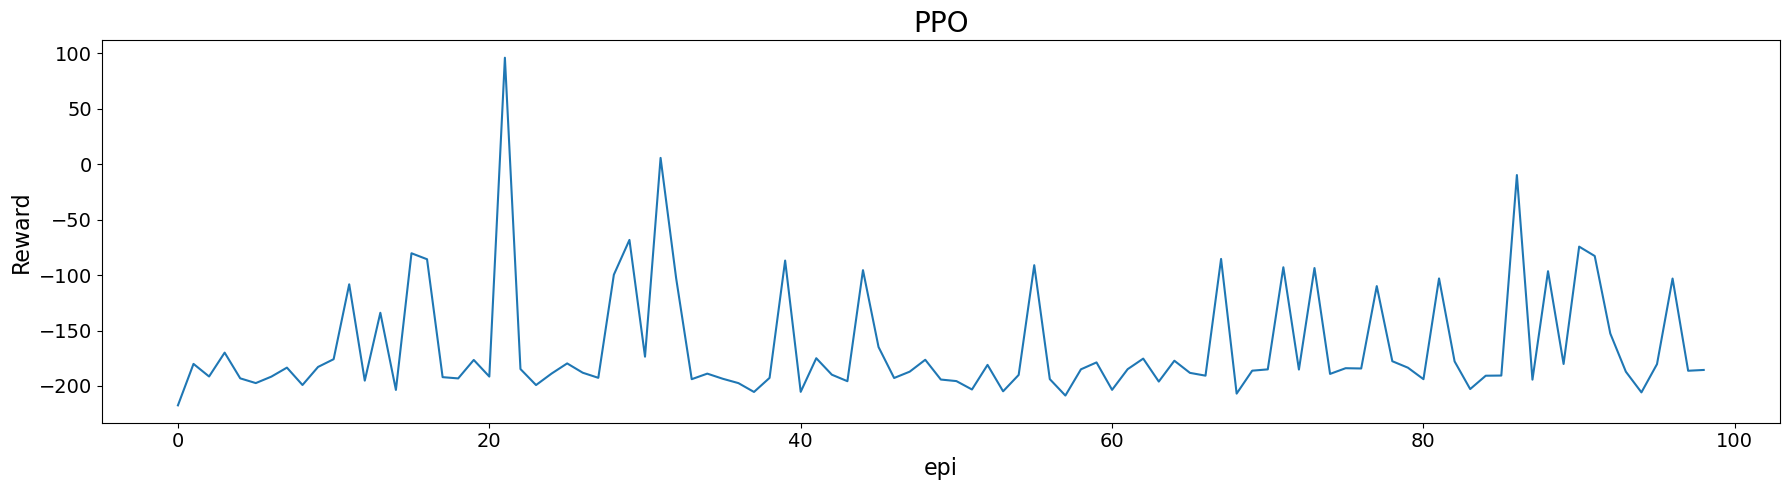

In [49]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18, 5))
plt.plot(np.array(score_lst))

plt.title('PPO', fontsize=20)
plt.xlabel('epi', fontsize=16)
plt.ylabel('Reward', fontsize=16)
plt.xticks(fontsize=14)  # X축 숫자 폰트 크기
plt.yticks(fontsize=14)  # Y축 숫자 폰트 크기
plt.tight_layout()
plt.show()

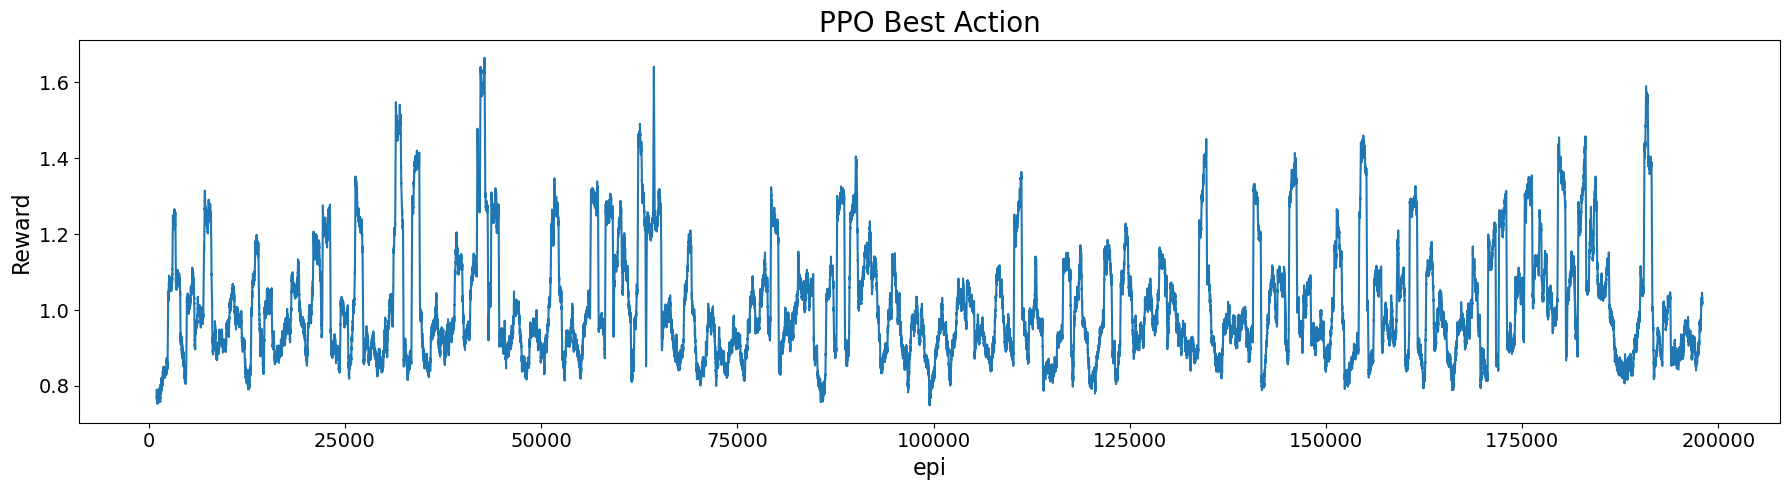

In [62]:
plt.figure(figsize=(18, 5))
plt.plot(pd.DataFrame(a_lst).rolling(window=1000).mean())

plt.title('PPO Best Action', fontsize=20)
plt.xlabel('epi', fontsize=16)
plt.ylabel('Reward', fontsize=16)
plt.xticks(fontsize=14)  # X축 숫자 폰트 크기
plt.yticks(fontsize=14)  # Y축 숫자 폰트 크기
plt.tight_layout()
plt.show()

In [63]:
np.array(a_lst).mean()

1.0099191919191919